In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [35]:
df = pd.read_csv('GBPUSD_open_5year.csv')

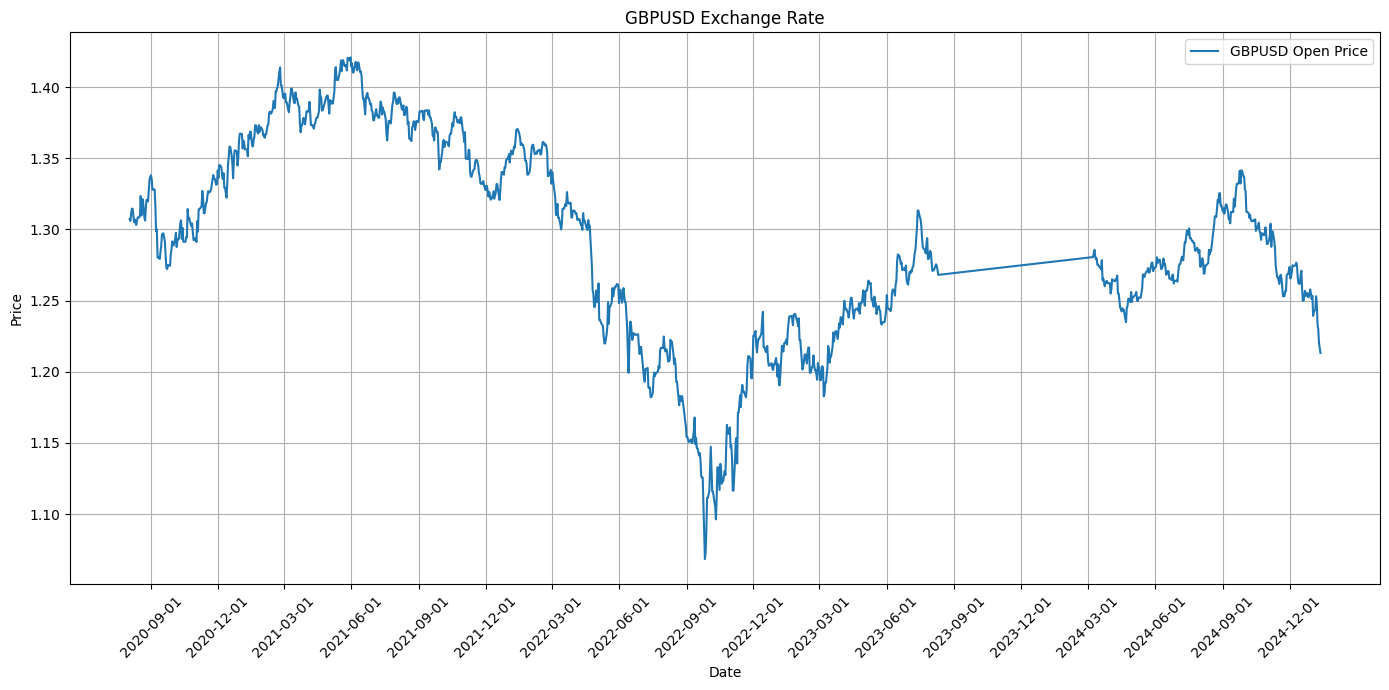

In [36]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.sort_values(by="Date", inplace=True)


plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Open'], label='GBPUSD Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GBPUSD Exchange Rate')


plt.xticks(pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='3MS'))


plt.xticks(rotation=45)


plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Open', 'Time']])

In [39]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)

test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

print(f"Training Data: {train_data.shape}")
print(f"Validation Data: {val_data.shape}")
print(f"Test Data: {test_data.shape}")


Training Data: (840, 3)
Validation Data: (180, 3)
Test Data: (180, 3)


In [40]:
target = 'Open'
y_val = val_data[target].values
y_test = test_data[target].values
y_train = train_data[target].values

In [41]:
X_train = scaler.transform(train_data[['Open', 'Time']])
X_val = scaler.transform(val_data[['Open', 'Time']])
X_test = scaler.transform(test_data[['Open', 'Time']])

X_train = X_train.reshape(-1, 2)
X_val = X_val.reshape(-1, 2)
X_test = X_test.reshape(-1, 2)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")


Shape of X_train: (840, 2)
Shape of X_val: (180, 2)
Shape of X_test: (180, 2)


In [42]:
#build model
dnn_model = Sequential()

dnn_model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
dnn_model.add(Dense(units=32, activation='relu'))
dnn_model.add(Dense(units=16, activation='relu'))
dnn_model.add(Dense(units=8, activation='relu'))
dnn_model.add(Dense(units=4, activation='relu'))

# Output layer
dnn_model.add(Dense(units=1))

dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

history = dnn_model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

test_loss = dnn_model.evaluate(X_test, y_test)
print(f"Test Loss (DNN): {test_loss}")


Epoch 1/60


/home/mahdi/Keras_trainning/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6454 - mae: 1.2800 - mse: 1.6454 - val_loss: 1.2293 - val_mae: 1.1087 - val_mse: 1.2293
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1552 - mae: 1.0692 - mse: 1.1552 - val_loss: 0.3471 - val_mae: 0.5888 - val_mse: 0.3471
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2370 - mae: 0.4345 - mse: 0.2370 - val_loss: 0.1180 - val_mae: 0.3360 - val_mse: 0.1180
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - mae: 0.0850 - mse: 0.0111 - val_loss: 0.0346 - val_mae: 0.1748 - val_mse: 0.0346
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - mae: 0.0567 - mse: 0.0044 - val_loss: 0.0347 - val_mae: 0.1744 - val_mse: 0.0347
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - mae: 0.0498 - mse: 0.0039 - val_loss: 0.0390 - val_mae: 0.1861 - val_mse: 0.0390
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0483 - mse: 0.0036 - val_loss: 0.0378 - val_mae:

In [43]:
y_pred = dnn_model.predict(X_test)

y_pred = scaler.inverse_transform(np.column_stack((y_pred, np.zeros(y_pred.shape))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros(y_test.shape))))[:, 0]

mae_dnn = mean_absolute_error(y_test_actual, y_pred)
mse_dnn = mean_squared_error(y_test_actual, y_pred)
r2_dnn = r2_score(y_test_actual, y_pred)
mape_dnn = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100 

print(f"DNN Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_dnn:.4f}")
print(f"Mean Squared Error (MSE): {mse_dnn:.4f}")
print(f"R² Score: {r2_dnn:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dnn:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
DNN Model Performance on Test Data:
Mean Absolute Error (MAE): 0.0104
Mean Squared Error (MSE): 0.0001
R² Score: -0.4654
Mean Absolute Percentage Error (MAPE): 0.69%


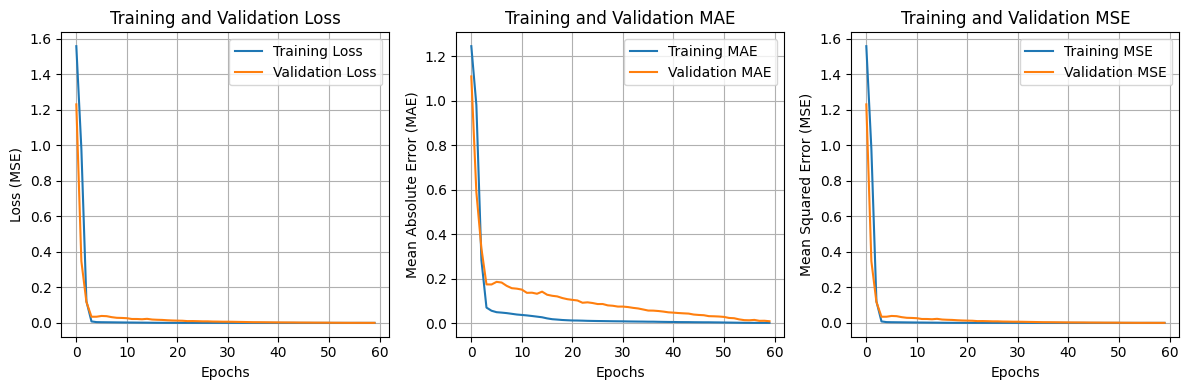

In [44]:
# Plotting
history_dict = history.history

#Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

#MAE
plt.subplot(1, 3, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

#MSE
plt.subplot(1, 3, 3)
plt.plot(history_dict['mse'], label='Training MSE')
plt.plot(history_dict['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
